In [2]:
import pandas as pd

# Load the dataset
file_path = "WA_Fn-UseC_-HR-Employee-Attrition.csv"
df = pd.read_csv(file_path)

# Display basic info and first few rows
df.info(), df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

(None,
    Age Attrition     BusinessTravel  DailyRate              Department  \
 0   41       Yes      Travel_Rarely       1102                   Sales   
 1   49        No  Travel_Frequently        279  Research & Development   
 2   37       Yes      Travel_Rarely       1373  Research & Development   
 3   33        No  Travel_Frequently       1392  Research & Development   
 4   27        No      Travel_Rarely        591  Research & Development   
 
    DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
 0                 1          2  Life Sciences              1               1   
 1                 8          1  Life Sciences              1               2   
 2                 2          2          Other              1               4   
 3                 3          4  Life Sciences              1               5   
 4                 2          1        Medical              1               7   
 
    ...  RelationshipSatisfaction StandardHours  Stoc

In [4]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Selecting only numerical columns for now
num_cols = df.select_dtypes(include=['int64']).columns.tolist()

# Encoding categorical features
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
label_encoders = {col: LabelEncoder() for col in cat_cols}

# Apply label encoding
for col in cat_cols:
    df[col] = label_encoders[col].fit_transform(df[col])

# Scaling the numerical data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[num_cols])

# Checking processed data shape
df_scaled.shape


(1470, 26)

In [6]:
from sklearn.cluster import Birch, DBSCAN

# Applying BIRCH clustering
birch_model = Birch(n_clusters=3)
birch_labels = birch_model.fit_predict(df_scaled)

# Applying DBSCAN clustering
dbscan_model = DBSCAN(eps=1.5, min_samples=5)
dbscan_labels = dbscan_model.fit_predict(df_scaled)

# Checking unique clusters in both models
birch_clusters = set(birch_labels)
dbscan_clusters = set(dbscan_labels)

birch_clusters, dbscan_clusters


({0, 1, 2}, {-1})

In [8]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier

# 1. Variance Threshold - Removing low-variance features
var_thresh = VarianceThreshold(threshold=0.1)  # Removing near-constant features
df_var_filtered = var_thresh.fit_transform(df_scaled)

# 2. Feature Importance using RandomForest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(df_scaled, df['Attrition'])  # Using 'Attrition' as a target for importance

# Get feature importances
feature_importances = rf_model.feature_importances_
important_features = [num_cols[i] for i in range(len(num_cols)) if feature_importances[i] > 0.02]  # Selecting significant features

df_var_filtered.shape, important_features


((1470, 24),
 ['Age',
  'DailyRate',
  'DistanceFromHome',
  'Education',
  'EmployeeNumber',
  'EnvironmentSatisfaction',
  'HourlyRate',
  'JobInvolvement',
  'JobLevel',
  'JobSatisfaction',
  'MonthlyIncome',
  'MonthlyRate',
  'NumCompaniesWorked',
  'PercentSalaryHike',
  'RelationshipSatisfaction',
  'StockOptionLevel',
  'TotalWorkingYears',
  'TrainingTimesLastYear',
  'WorkLifeBalance',
  'YearsAtCompany',
  'YearsInCurrentRole',
  'YearsSinceLastPromotion',
  'YearsWithCurrManager'])

In [10]:
# Selecting only important features
df_selected = df[important_features]

# Scaling selected features
df_selected_scaled = scaler.fit_transform(df_selected)

# Applying BIRCH clustering again
birch_model = Birch(n_clusters=3)
birch_labels = birch_model.fit_predict(df_selected_scaled)

# Applying DBSCAN clustering again with adjusted parameters
dbscan_model = DBSCAN(eps=2, min_samples=5)
dbscan_labels = dbscan_model.fit_predict(df_selected_scaled)

# Checking unique clusters in both models
birch_clusters = set(birch_labels)
dbscan_clusters = set(dbscan_labels)

birch_clusters, dbscan_clusters


({0, 1, 2}, {-1})

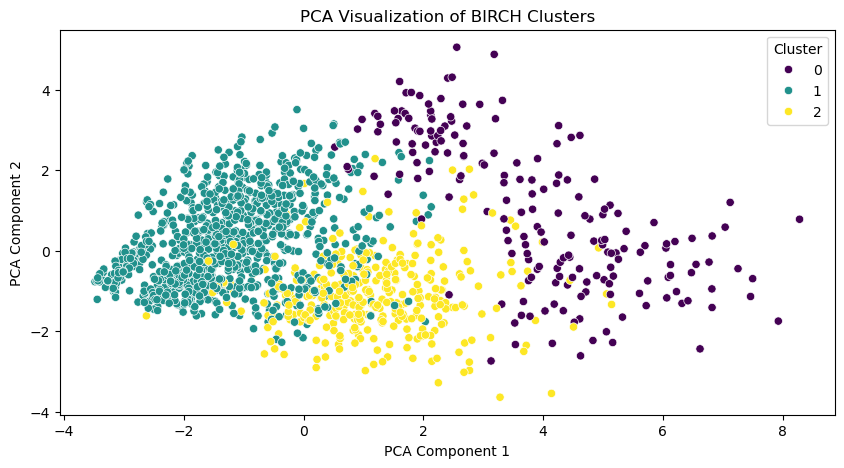

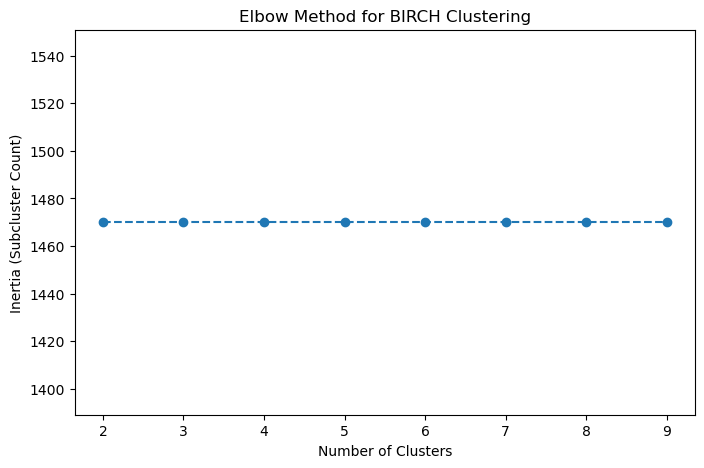

Silhouette Score for BIRCH: 0.089


C:\Users\prasa\AppData\Local\Temp\ipykernel_21820\3788442359.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=birch_labels, palette="coolwarm")


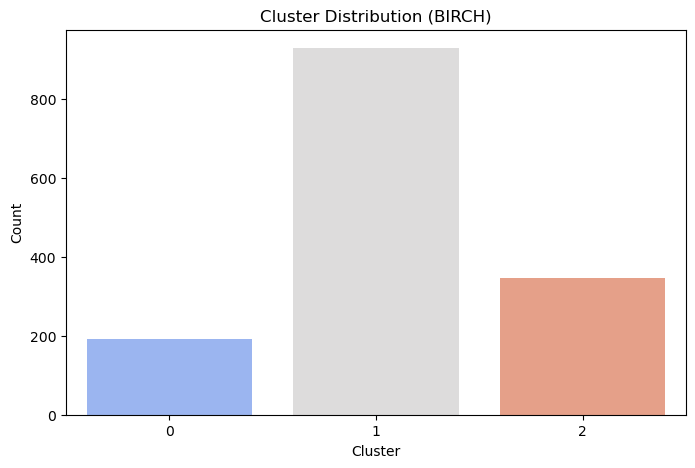

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Applying PCA for visualization (2D)
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_selected_scaled)

# Scatter plot for BIRCH clusters
plt.figure(figsize=(10, 5))
sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], hue=birch_labels, palette="viridis")
plt.title("PCA Visualization of BIRCH Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

# Elbow method for optimal clusters (inertia)
inertia_values = []
cluster_range = range(2, 10)
for k in cluster_range:
    model = Birch(n_clusters=k)
    model.fit(df_selected_scaled)
    inertia_values.append(model.subcluster_centers_.shape[0])

plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia_values, marker='o', linestyle='--')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia (Subcluster Count)")
plt.title("Elbow Method for BIRCH Clustering")
plt.show()

# Silhouette Score for cluster quality
silhouette_avg = silhouette_score(df_selected_scaled, birch_labels)
print(f"Silhouette Score for BIRCH: {silhouette_avg:.3f}")

# Cluster Distribution Bar Chart
plt.figure(figsize=(8, 5))
sns.countplot(x=birch_labels, palette="coolwarm")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.title("Cluster Distribution (BIRCH)")
plt.show()
